<a href="https://colab.research.google.com/github/Jia-wei-liao/NPDE_final_project/blob/main/DGM_Poisson2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random, time
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input

# for writing to csv
import pandas as pd

# 1. Set up the Neural Network

In [ ]:
class Residual_block(tf.keras.Model):
  def __init__(self, n_Neural):
    super(Residual_block, self).__init__()
    self.Dense1 = Dense(n_Neural)
    self.Dense2 = Dense(n_Neural)
  
  def call(self, inputs):
    x = self.Dense1(inputs)
    x = tf.math.sigmoid(x)*x
    x = self.Dense2(x)
    x = tf.math.sigmoid(x)*x + x

    return x


class ResNet(tf.keras.Model):
  def __init__(self):
    super(ResNet, self).__init__()
    self.RB1 = Residual_block(20)
    self.RB2 = Residual_block(20)
    self.RB3 = Residual_block(20)
    self.FinalLayer = Dense(1)

    self.input_layer = Input(shape=(2))
    self.outputs = self.call(self.input_layer)

    super(ResNet, self).__init__(inputs=self.input_layer, outputs=self.outputs)
    
  def call(self, inputs, training=True):
    x = self.RB1(inputs)
    x = self.RB2(x)
    x = self.RB3(x)
    x = self.FinalLayer(x)

    return x

# 2. Set the Parameter

In [ ]:
model = ResNet()
model.build((None, 2))
model.summary()

Model: "res_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
residual_block (Residual_blo (None, 20)                480       
_________________________________________________________________
residual_block_1 (Residual_b (None, 20)                840       
_________________________________________________________________
residual_block_2 (Residual_b (None, 20)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 21        
Total params: 2,181
Trainable params: 2,181
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 5000
Lambda = 1
optimizer = tf.keras.optimizers.Adam(lr=5e-4)
mse = tf.keras.losses.MeanSquaredError()
N = 100  # number of interior sample point
M = 30  # number of boundary sample point

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# 3. Define the function and exact solution

In [ ]:
def f(X):
  x, y = X[:, 0], X[:, 1]
  return 4+x*0+y*0


def u_exact(X):
  x, y = X[:, 0], X[:, 1]
  return x**2+y**2

In [ ]:
def generate_interior_point(num):
  sample = tf.random.uniform((num,2), minval=0, maxval=1, dtype=tf.dtypes.float32)
  return sample


def generate_boundary_point(num):
  
  left = np.random.rand(10,1)
  right = np.random.randint(0, 2, (10,1))
  random = np.concatenate([left, right], axis=1)
  change = np.random.choice(a=[True, False], size=(10))
  random[change, 0], random[change, 1] = random[change, 1], random[change, 0]
  random = tf.constant(random, dtype=tf.float32)
  return random


def BdyLoss(Xb, model, u_exact):
  U = model(Xb)
  u = u_exact(Xb)
  return mse(U, u)

# 4. Training

In [ ]:
#model_name = 'poisson_gravity'
loss_interior = []
loss_boundary = []
loss_total = []
tic = time.time()
for ep in range(1, epochs+1):
  with tf.GradientTape() as t3:
    with tf.GradientTape() as t2:
      with tf.GradientTape() as t1:
        X, Xb = generate_interior_point(N), generate_boundary_point(M)
        t1.watch(X)
        t2.watch(X)
        U = model(X)

      # Gradient
      DU = t1.gradient(U, X)

    # Laplacian
    DDU = t2.gradient(DU, X)
    LU = tf.reduce_sum(DDU, 1)
    F = f(X)

    Li, Lb = mse(LU, F)/N, BdyLoss(Xb, model, u_exact)/M
    loss = Li + Lb*Lambda

  grads = t3.gradient(loss, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))

  # append loss
  loss_interior.append(np.mean(Li))
  loss_boundary.append(np.mean(Lb))
  loss_total.append(np.mean(loss))

  if ep%1000==1:
    #print(f'Epoch: {ep}, Time: {time.time()-tic:.0f}, InteriorLoss: {Li:.8f}, BoundaryLoss: {Lb:.8f}, TotalLoss: {float(loss):.8f}')
    print(f'Epoch: {ep}, Time: {time.time()-tic:.0f}, InteriorLoss: {np.mean(Li):.8f}, BoundaryLoss: {np.mean(Lb):.8f}, TotalLoss: {np.mean(float(loss)):.8f}')

Epoch: 1, Time: 0, InteriorLoss: 0.16143674, BoundaryLoss: 0.01658897, TotalLoss: 0.17802571
Epoch: 1001, Time: 36, InteriorLoss: 0.00003412, BoundaryLoss: 0.00002518, TotalLoss: 0.00005930
Epoch: 2001, Time: 71, InteriorLoss: 0.00000473, BoundaryLoss: 0.00000214, TotalLoss: 0.00000687
Epoch: 3001, Time: 107, InteriorLoss: 0.00000129, BoundaryLoss: 0.00000101, TotalLoss: 0.00000230
Epoch: 4001, Time: 143, InteriorLoss: 0.00000060, BoundaryLoss: 0.00000045, TotalLoss: 0.00000105


# 5. Plot the figure

In [ ]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
[xx, yy] = np.meshgrid(x, y)
xx = xx.reshape(-1,1)
yy = yy.reshape(-1,1)
X = np.hstack([xx,yy])

U = np.array(model(X)).reshape(100,100)
u = u_exact(X).reshape(100,100)

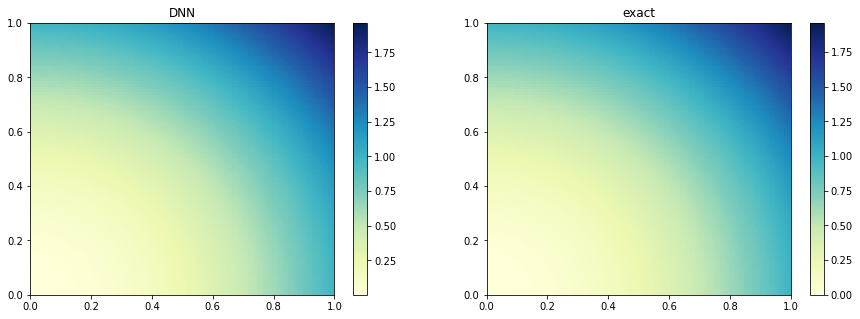

In [ ]:
def PlotMesh(x, y, u, title):
  u = u[:-1, :-1]
  levels = MaxNLocator(nbins=15).tick_values(u.min(), u.max())
  cmap = plt.get_cmap('YlGnBu')
  im = plt.pcolormesh(x, y, u, cmap=cmap)
  plt.colorbar(im)
  plt.title(title)


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
PlotMesh(x, y, U, 'DNN')
plt.subplot(1,2,2)
PlotMesh(x, y, u, 'exact')
plt.show()

# 6. Compute the error

InfNorm: 0.00439360, TwoNorm: 0.14046935


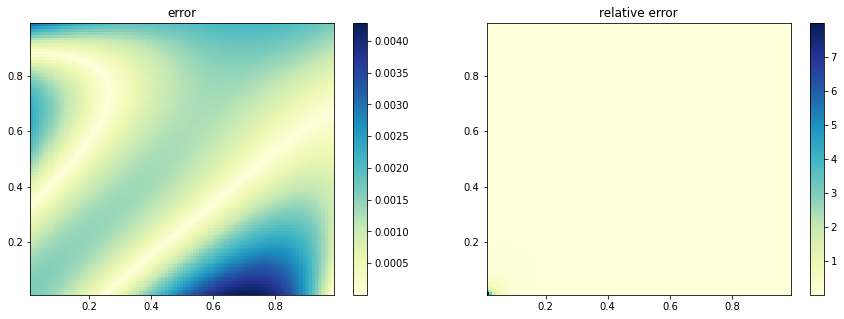

In [ ]:
error = abs(U-u)
relative_error = error/(u+1e-8)
InfNorm = np.max(error)
TwoNorm = np.sqrt(np.sum(error**2))
print(f'InfNorm: {InfNorm:.8f}, TwoNorm: {TwoNorm:.8f}')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
PlotMesh(x[1:99], y[1:99], error[1:99, 1:99], 'error')
plt.subplot(1,2,2)
PlotMesh(x[1:99], y[1:99], relative_error[1:99, 1:99], 'relative error')
plt.show()

e2 = 0.001768989591032873


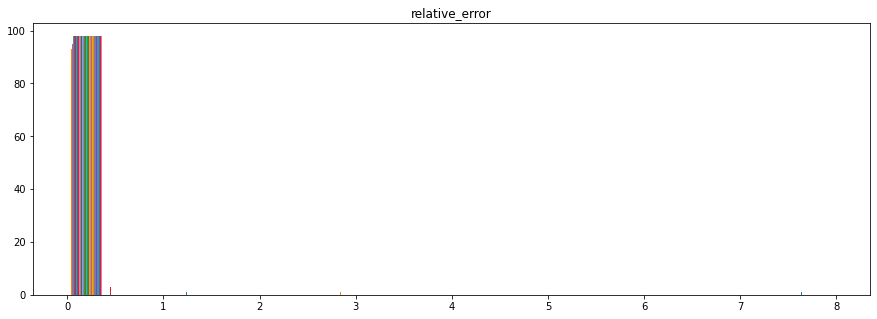

In [ ]:
def Norm2(U, u):
  diff = U-u
  return np.sqrt(np.sum(diff**2))


def e2(U, u):
  return Norm2(U, u)/Norm2(u, 0)


print(f'e2 = {e2(U, u)}')


plt.figure(figsize=(15,5))
ax = plt.axes()
ax.hist(relative_error[1:99, 1:99], bins=20)
plt.title('relative_error')
plt.show()